In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.utils import img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


dataset_path = '/content/drive/MyDrive/Wroksheet4/devnagari_digit/DevanagariHandwrittenDigitDataset/Test'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Load images
def load_images(dataset_path, image_size=(32, 32)):
    data = []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                try:
                    img = Image.open(img_path).convert('L')  # grayscale
                    img = img.resize(image_size)
                    img = img_to_array(img) / 255.0  # Normalize
                    data.append(img)
                except:
                    pass
    return np.array(data)

images = load_images(dataset_path)
images = images.reshape(-1, 32, 32, 1)  # reshape for CNN input

# Add noise (Gaussian)
def add_noise(data, noise_factor=0.5):
    noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy, 0., 1.)

noisy_images = add_noise(images)

# Split dataset
x_train, x_test, x_train_noisy, x_test_noisy = train_test_split(
    images, noisy_images, test_size=0.2, random_state=42
)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

def build_autoencoder(input_shape=(32, 32, 1)):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(input_img, decoded)
    model.compile(optimizer=Adam(), loss='binary_crossentropy')
    return model

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,041 (652.50 KB)

 Trainable params: 167,041 (652.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - loss: 0.5912 - val_loss: 0.3214
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2908 - val_loss: 0.2381
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2254 - val_loss: 0.2080
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2027 - val_loss: 0.1937
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1909 - val_loss: 0.1845
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1833 - val_loss: 0.1797
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1782 - val_loss: 0.1784
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1732 - val_loss: 0.1728
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1737 - val_loss: 0.1706
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1707 - val_loss: 0.1670
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1672 - val_loss: 0.1653
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step


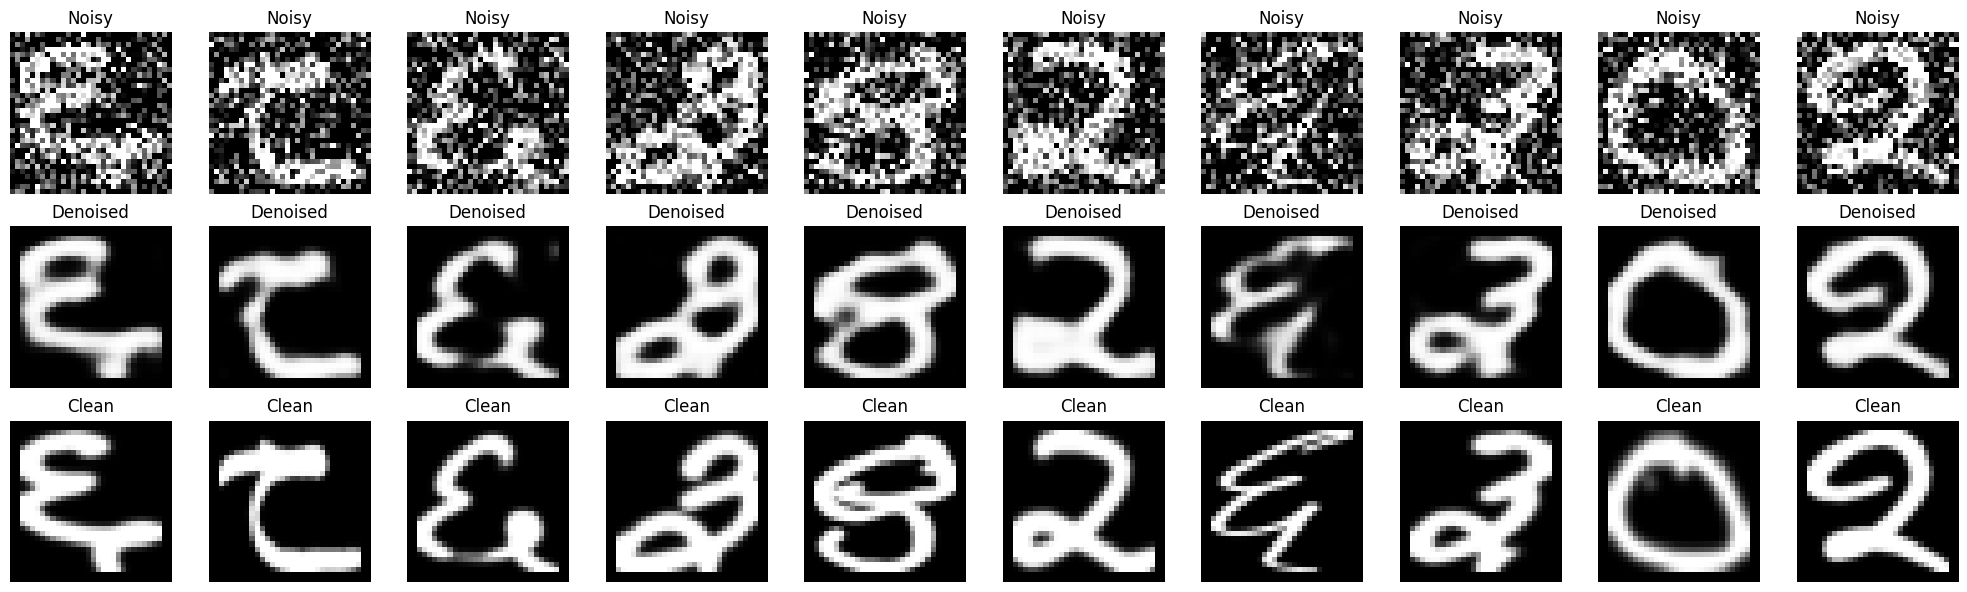

In [ ]:
def plot_images(noisy, denoised, clean, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Noisy
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy[i].reshape(32, 32), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoised
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised[i].reshape(32, 32), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

        # Clean
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean[i].reshape(32, 32), cmap='gray')
        plt.title("Clean")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Predict
denoised_images = autoencoder.predict(x_test_noisy)
plot_images(x_test_noisy, denoised_images, x_test)


In [ ]:
def salt_pepper_noise(image, amount=0.01):
    noisy = image.copy()
    row, col, ch = image.shape[1], image.shape[2], image.shape[3]
    num_salt = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i, int(num_salt)) for i in image.shape[1:3]]
    noisy[:, coords[0], coords[1], :] = 1

    num_pepper = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i, int(num_pepper)) for i in image.shape[1:3]]
    noisy[:, coords[0], coords[1], :] = 0
    return noisy


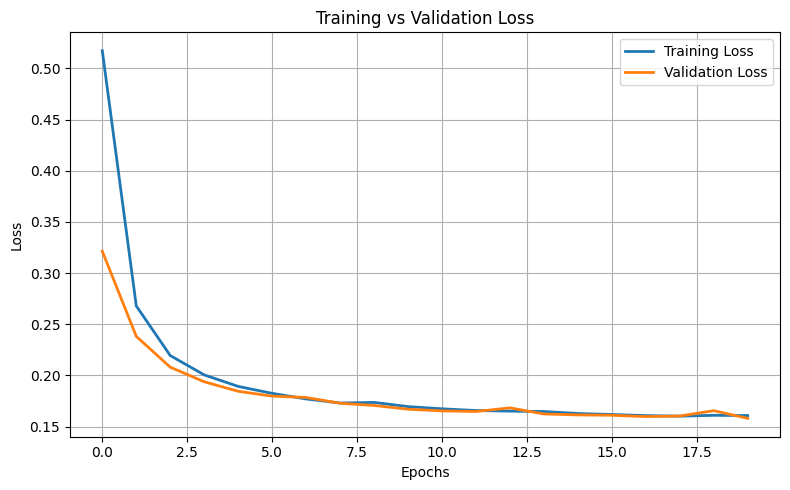

In [ ]:
# ===========================
# 3.1 VISUALIZE TRAINING & VALIDATION LOSS
# ===========================
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
